In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import cv2 
import os 
from random import shuffle 
from tqdm import tqdm 


import warnings
warnings.filterwarnings('ignore')
import os

In [2]:
train_icecream = "ice_cream"
train_waffles= "waffles"
image_size=128

In [3]:
def train_data():
    train_data_icecream = [] 
    train_data_waffles=[]
    for image1 in tqdm(os.listdir(train_icecream)): 
        path = os.path.join(train_icecream, image1)
        img1 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img1 = cv2.resize(img1, (image_size, image_size))
        train_data_icecream.append(img1) 
        
    for image2 in tqdm(os.listdir(train_waffles)): 
        path = os.path.join(train_waffles, image2)
        img2 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img2 = cv2.resize(img2, (image_size, image_size))
        train_data_waffles.append(img2) 
    
    train_data= np.concatenate((np.asarray(train_data_icecream),np.asarray(train_data_waffles)),axis=0)
    return train_data 

In [4]:
train_data = train_data() 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:00<00:00, 591.28it/s]


In [5]:
x_data=train_data
x_data = (x_data-np.min(x_data))/(np.max(x_data)-np.min(x_data))


In [6]:
z1 = np.zeros(343)
o1 = np.ones(355)

Y_train = np.concatenate((o1, z1), axis=0)

In [7]:
y_data=Y_train.reshape(x_data.shape[0],1)
x_data=x_data.reshape(x_data.shape[0],-1).T


In [8]:

#Data is shuffled because ones and zeros are concatenated consecutively
a=int(x_data.shape[1])

shuffled=list(np.random.permutation(a))

shuffled_x=x_data[:,shuffled].reshape((16384,698))
shuffled_y=y_data.T[:,shuffled].reshape((1,698))

b=int(698*0.8)
x_train=shuffled_x[:,0:b].reshape((16384,b))
y_train=shuffled_y[:,0:b].reshape((1,b))
r=int(698-b)
x_test=shuffled_x[:,b:698].reshape((16384,r))
y_test=shuffled_y[:,b:698].reshape((1,r))


In [9]:
print(x_train.shape)
layerdims =[16384,4,1]
lambd=1

(16384, 558)


In [10]:
def initialize_parameters(layerdims):
    parameters = {}
           
    for l in range(1, len(layerdims)):
      
        parameters['W' + str(l)] = np.random.randn(layerdims[l],layerdims[l-1])*(np.sqrt(2/layerdims[l-1]))
        parameters['b' + str(l)] = np.zeros((layerdims[l],1))
       
        
    return parameters

In [11]:
def forward(A, W, b):
  
   
    Z = np.dot(W,A)+b
    cache = (A, W, b)
    
    return Z, cache

In [12]:
def activation_forward(A_prev, W, b, activation):
   
    if activation == "sigmoid":
      
        Z, linear_cache = forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
     
    elif activation == "relu":
        
        Z, linear_cache = forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    cache = (linear_cache, activation_cache)

    return A, cache

In [13]:
def compute_cost(AL, Y,cache1,cache2):
   
    m = Y.shape[1]
    (linear_cache1,activation_cache1)=cache1
    (linear_cache2,activation_cache2)=cache2
    A1,W1,b1=linear_cache1
    A2,W2,b2=linear_cache2
   
    cost = (-1/m)*np.sum(Y*np.log(AL)+(1-Y)*(np.log(1-AL)))+(1/2)*(lambd/m)*(np.sum(np.square(W1))+np.sum(np.square(W2)))
  
    
    cost = np.squeeze(cost)      
  
    
    return cost

In [14]:
def backward(dZ, cache):
   
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
   
    dW = (1/m)*(dZ).dot(A_prev.T)+((lambd)/m)*(W)
    db = (1/m)*(np.sum(dZ,axis=1,keepdims=True))
    dA_prev = np.dot(W.T,dZ)
   
    
    return dA_prev, dW, db

In [15]:
def activation_backward(dA, cache, activation):
   
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        
        Z=activation_cache
        dZ=np.array(dA,copy=True)
        dZ[Z<=0]=0
        dA_prev, dW, db =backward(dZ,linear_cache)
      
    elif activation == "sigmoid":
       
        Z=activation_cache
        s1=1/(1+np.exp(-Z))
        dZ =dA*s1*(1-s1)
        dA_prev, dW, db =backward(dZ,linear_cache)
      
    
    return dA_prev, dW, db

In [16]:
def sigmoid(Z):
   
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

def relu(Z):
    A = np.maximum(0,Z)
    cache = Z 
    return A, cache





In [17]:
def initialize_adam(parameters) :
   
    L = len(parameters) // 2 
    v = {}
    s = {}
    
   
    for l in range(L):
   
        v["dW" + str(l+1)] = np.zeros( parameters["W" + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros( parameters["b" + str(l+1)].shape)
        s["dW" + str(l+1)] = np.zeros( parameters["W" + str(l+1)].shape)
        s["db" + str(l+1)] = np.zeros( parameters["b" + str(l+1)].shape)
  
    
    return v, s

In [18]:
def update_parameter_with_adam(parameters, grads, v, s, t, learning_rate=0.001,beta1=0.9, beta2=0.99,  epsilon = 1e-8):
   
    
    L = len(parameters) // 2    

    v_corrected = {}                        
    s_corrected = {}                       
    for l in range(L):
       
        v["dW" + str(l+1)] = beta1*( v["dW" + str(l+1)] )+(1-beta1)*(grads["dW"+str(l+1)])
        v["db" + str(l+1)] =  beta1*( v["db" + str(l+1)] )+(1-beta1)*(grads["db"+str(l+1)])
      
        v_corrected["dW" + str(l+1)] =   v["dW" + str(l+1)]/(1-np.power(beta1,t))
        v_corrected["db" + str(l+1)] =  v["db" + str(l+1)]/(1-np.power(beta1,t))
      
        s["dW" + str(l+1)] =  beta2*( s["dW" + str(l+1)] )+(1-beta2)*(np.power(grads["dW"+str(l+1)],2))
        s["db" + str(l+1)] = beta2*( s["db" + str(l+1)] )+(1-beta2)*(np.power(grads["db"+str(l+1)],2))
       
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)]/(1-np.power(beta2,t))
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)]/(1-np.power(beta2,t))
       
        parameters["W" + str(l+1)] =parameters["W" + str(l+1)]-(learning_rate)*(v_corrected["dW" + str(l+1)]/ (np.sqrt(s_corrected["dW" + str(l + 1)]) + epsilon))
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] -(learning_rate)*(v_corrected["db" + str(l+1)]/ (np.sqrt(s_corrected["db" + str(l + 1)]) + epsilon))
    

    return parameters, v, s

In [19]:
def neural_model(X, Y, layerdims, learning_rate = 0.001, num_iterations = 1000, print_cost=False):
   
   
    grads = {}
    costs = []                              
    m = X.shape[1]                           
    parameters = initialize_parameters(layerdims)
    v,s=initialize_adam(parameters)
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    t=0
    for i in range(0, num_iterations):

        
        A1, cache1 = activation_forward(X, W1, b1, "relu")
        A2, cache2 = activation_forward(A1, W2, b2, "sigmoid")
        
       
        cost = compute_cost(A2, Y,cache1,cache2)
       
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
       
        dA1, dW2, db2 = activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = activation_backward(dA1, cache1, "relu")
      
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        t=t+1
        parameters, v, s = update_parameter_with_adam(parameters, grads, v, s,
                                                               t, learning_rate,0.9,0.999, 1e-8)
        
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
 

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.6990453432025633
Cost after iteration 100: 0.39018311803963385
Cost after iteration 200: 0.22298624020788702
Cost after iteration 300: 0.15054607055047226
Cost after iteration 400: 0.11975260199572518
Cost after iteration 500: 0.10286032165908428
Cost after iteration 600: 0.09634857546810914
Cost after iteration 700: 0.09027577226640729
Cost after iteration 800: 0.08481934183877088
Cost after iteration 900: 0.0798846615732522


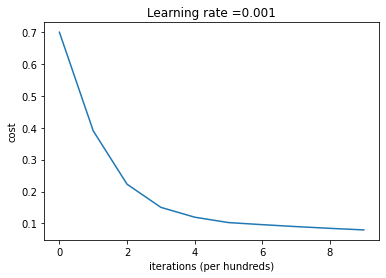

In [20]:

parameters = neural_model(x_train, y_train, layerdims, num_iterations = 1000, print_cost=True)


In [21]:
def predict(X, y, parameters):
   
    m = X.shape[1]
    n = len(parameters) // 2 
    p = np.zeros((1,m))
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    A1, cache1 = activation_forward(X, W1, b1, "relu")
    output, cache2 = activation_forward(A1, W2, b2, "sigmoid")
    for i in range(0, output.shape[1]):
        if output[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [22]:
pred_train = predict(x_train, y_train, parameters)

Accuracy: 0.9999999999999998


In [23]:
pred_test = predict(x_test, y_test, parameters)

Accuracy: 0.6499999999999999
